In [1]:
import numpy as np
import importlib
import matplotlib as mpl
import matplotlib.pylab as plt
import time
from copy import deepcopy
import torch
import IPython.display as IPd
import pandas as pd
import dill as pickle
from multiprocessing import Pool

from stg_energy.common import col, svg, samples_nd, get_labels_8pt, reorder_stats
from stg_energy.fig5_cc.viz import vis_sample_plain
from pyloric import simulate, summary_stats, create_prior
from stg_energy.fig7_temp.process_samples import merge_samples
import stg_energy.fig7_temp.viz as viz
from sbi.utils import ActiveSubspace

from stg_energy import check_if_close_to_obs

import pyabf

# Fig 7: posterior over temperatures

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PANEL_exp1 = '../svg/panel_exp1.svg'
PANEL_exp2 = '../svg/panel_exp2.svg'

PANEL_A1 = '../svg/panel_a1.svg'
PANEL_A2 = '../svg/panel_a2.svg'

PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'

PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'
PANEL_C3 = '../svg/panel_c3.svg'

PANEL_D1 = '../svg/panel_d1.svg'
PANEL_D2 = '../svg/panel_d2.svg'

PANEL_E1 = '../svg/panel_e1.svg'
PANEL_E2 = '../svg/panel_e2.svg'
PANEL_E3 = '../svg/panel_e3.svg'
PANEL_E4 = '../svg/panel_e4.svg'

PANEL_F = '../svg/panel_f.svg'
PANEL_G = '../svg/panel_g.svg'

### Load samples from 11 deg, 15deg, 19deg, 23deg, 27deg

In [31]:
xo11 = np.load("../../../results/experimental_data/xo_11deg_078.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg_078.npy")

xo11_or = np.load("../../../results/experimental_data/xo_11deg.npy")

for x in xo11:
    print(x)

1364.451376146789
272.78181818181827
141.99545454545435
505.7348214285717
0.19992051233965857
0.10406780118940519
0.37065067342800223
0.42341758774276916
0.5694534831862397
577.7327102803752
776.9915887850472
305.007476635515
57.6999999999993
0.2235385459442726
0.04228805878223679
2.5
2.5
2.5


### Show data at 11 degree

In [32]:
npz = np.load('../../../results/experimental_data/supplementary_traces/data_857_016_0049.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [33]:
start_index = 100000
end_index   = 130000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

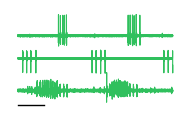

In [34]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 7.5+pdn[start_index:end_index]/np.max(pdn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 6.45+lpn[start_index:end_index]/2.5/np.max(lpn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn[start_index:end_index]/1.2/np.max(pyn), c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)
    
#     plt.savefig(PANEL_exp1, facecolor='None', transparent=True)
    plt.show()

### Show data at 27 degree

In [35]:
npz = np.load('../../../results/experimental_data/supplementary_traces/data_857_016_0069.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [36]:
start_index = 100000
end_index   = 130000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

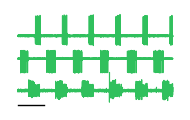

In [37]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 7.5+pdn[start_index:end_index]/np.max(pdn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 6.45+lpn[start_index:end_index]/2.5/np.max(lpn), c=col['GT'], lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn[start_index:end_index]/1.2/np.max(pyn), c=col['GT'], lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)
    
#     plt.savefig(PANEL_exp1, facecolor='None', transparent=True)
    plt.show()

# Simulate samples from 11 deg posterior

In [38]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)

In [39]:
torch.manual_seed(0)
posterior_samples_11 = posterior.sample((10000,), x=xo11)

prior_11 = create_prior()
param_names = prior_11.sample((1,)).columns

posterior_pd1 = pd.DataFrame(posterior_samples_11, columns=param_names)

In [40]:
trace = simulate(posterior_pd1.loc[0], track_energy=True)
stats = summary_stats(trace, stats_customization={'energies': True, 'plateau_durations': True})

stat_names = stats.columns

In [41]:
def sim_func_11(samples):
    posterior_pd = pd.DataFrame(np.asarray([samples.numpy()]), columns=param_names)
    trace = simulate(posterior_pd.loc[0], track_energy=True, seed=0)
    stats = summary_stats(trace, stats_customization={'energies': True, 'plateau_durations': True})
    return stats.to_numpy()[0]

In [42]:
data = []
num_sims = 500
for kkk in range(1):
    with Pool(processes=12) as pool:
        data.append(pool.map(sim_func_11, posterior_samples_11[5000*kkk:5000*kkk+num_sims]))

In [62]:
x_11_11 = np.asarray(data)
x_11_11_reshape = np.reshape(x_11_11, (500, 21))

In [63]:
# x_11_11 = np.asarray(data)
close_enough = check_if_close_to_obs(x_11_11_reshape, xo=xo11[:15], check_burst_num=False, sloppiness=6.0)
x_11_11_reshape = x_11_11_reshape[close_enough]
x_11_11_reshape = pd.DataFrame(x_11_11_reshape, columns=stat_names)

In [64]:
num_of_valid = np.invert(np.any(np.isnan(x_11_11_reshape), axis=1))
print(np.sum(num_of_valid))

4


# Simulate samples from 27 deg posterior

In [21]:
with open(
    "../../../results/trained_neural_nets/inference/temp27_flow_notau_016_-35.57665352652927_tensor([83551]).pickle", "rb"
) as handle:
    posterior_27 = pickle.load(handle)

In [22]:
torch.manual_seed(0)
posterior_samples_27 = posterior_27.sample((10000,), x=xo27)

prior_27 = create_prior(
        customization={
            "Q10_gbar_mem": [True, True, True, True, True, True, True, True],
            "Q10_gbar_syn": [True, True],
            "Q10_tau_m": [False],
            "Q10_tau_h": [False],
            "Q10_tau_CaBuff": [False],
            "Q10_tau_syn": [False, False],
        },
    )
param_names = prior_27.sample((1,)).columns

### Simulate at 27 deg

In [114]:
def sim_func_27(samples):
    posterior_pd = pd.DataFrame(np.asarray([samples.numpy()]), columns=param_names)
    trace = simulate(posterior_pd.loc[0], temperature=299, track_energy=True, seed=0)
    stats = summary_stats(trace, stats_customization={'energies': True, 'plateau_durations': True})
    return stats.to_numpy()[0]

In [115]:
with Pool(processes=12) as pool:
    data = pool.map(sim_func_27, posterior_samples_27[:500])
x_27_27 = np.asarray(data)

In [116]:
x_27_27pd = pd.DataFrame(x_27_27, columns=stat_names)

In [117]:
close_enough = check_if_close_to_obs(x_27_27, xo=xo27[:15], check_burst_num=False, sloppiness=10.0)
x_27_27 = x_27_27[close_enough]
x_27_27 = pd.DataFrame(x_27_27, columns=stat_names)

In [118]:
num_of_valid = np.invert(np.any(np.isnan(x_27_27), axis=1))
print(np.sum(num_of_valid))

126


### Simulate at 11 deg

In [23]:
with Pool(processes=12) as pool:
    data = pool.map(sim_func_11, posterior_samples_27[:20000])
x_27_11 = np.asarray(data)

In [153]:
close_enough = check_if_close_to_obs(x_27_11, xo=xo11[:15], check_burst_num=False, sloppiness=6.0)
x_27_11 = x_27_11[close_enough]
x_27_11 = pd.DataFrame(x_27_11, columns=stat_names)

In [154]:
num_of_valid = np.invert(np.any(np.isnan(x_27_11), axis=1))
print(np.sum(num_of_valid))

668


### Simulate a sample from 27 posterior at 11 and 27 deg

In [155]:
time_vec = np.arange(0, 11000, 0.025)

In [156]:
# sample_index = 1
# counter = 0
# offsets = [82000, 16500]

# for temp in [283, 299]:

#     out_target = simulate(
#         posterior_pd.loc[sample_index],
#         seed=0,
#         temperature=temp,
#     )

#     with mpl.rc_context(fname="../../../.matplotlibrc"):
#         fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(2.0, 1.15))
#         fig = vis_sample_plain(
#             out_target,
#             time_vec,
#             ax,
#             time_len=int(shown_t / 0.025 * 1000),
#             col='k',
#             offset=offsets[counter],
#             scale_bar=False,
#         )
# #         if temp == 283:
# #             plt.savefig(PANEL_B1, facecolor='None', transparent=True)
# #         elif temp == 299:
# #             plt.savefig(PANEL_B2, facecolor='None', transparent=True)
#         plt.show()
#         counter += 1

In [124]:
min_num = min(x_27_11.shape[0], x_27_27.shape[0])
print("number of considered simulations:  ", min_num)
e_11 = np.sum(x_27_11['energies'].to_numpy()[:min_num], axis=1) / 10 / 1000
e_27 = np.sum(x_27_27['energies'].to_numpy()[:min_num], axis=1) / 10 / 1000

number of considered simulations:   62


In [125]:
print("Pearson correlation coefficient between energy consumption at 11 and 27 degree: ", np.corrcoef(e_11, e_27)[0, 1])

Pearson correlation coefficient between energy consumption at 11 and 27 degree:  0.1606881252213901


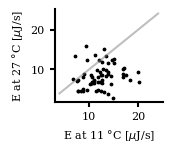

In [126]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.2))
    ax.scatter(e_11, e_27, s=3, c='k')
    ax.plot([4, 24], [4, 24], c='gray', alpha=0.5)
    ax.set_xlabel("E at 11 °C [$\mu$J/s]")
    ax.set_ylabel("E at 27 °C [$\mu$J/s]")
#     plt.savefig(PANEL_F, facecolor='None', transparent=True)

# Relation between energy efficiency and temperature robustness

### Load samples from 27deg posterior. Samples have been rejected if too far from obs at 11deg and then been simulated at 27deg

In [157]:
min_num = min(x_11_11.shape[0], x_27_11.shape[0])
print("number of considered simulations:  ", min_num)
all_total_energies_11 = x_11_11['energies'].to_numpy()[:min_num]
all_total_energies_27 = x_27_11['energies'].to_numpy()[:min_num]
# all_total_energies_rejection = x_11_11_rejection_nan['energies'].to_numpy()

number of considered simulations:   454


In [158]:
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1) / 10 / 1000 # per second, micro-Joule
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1) / 10 / 1000
# summed_energies_total_27_rejection = np.sum(np.asarray(all_total_energies_rejection), axis=1) / 10 / 1000

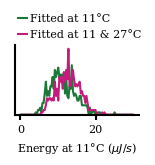

In [159]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

    hist_vals_11 = ax.hist(summed_energies_total_11[:900], range=(0, 30), bins=100, color='w')
    hist_vals_27 = ax.hist(summed_energies_total_27[:900], range=(0, 30), bins=100, color='w')

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#c51b7d')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_ylim([0, 52])
    ax.set_yticks([])

    plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11 & 27°C'), bbox_to_anchor=(0.6, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

#     plt.savefig(PANEL_D1, facecolor='None', transparent=True)

In [130]:
# with mpl.rc_context(fname='../../../.matplotlibrc'):
#     fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

#     hist_vals_11 = ax.hist(summed_energies_total_11[:900], range=(0, 30), bins=100, color='w')
#     hist_vals_27 = ax.hist(summed_energies_total_27_rejection[:900], range=(0, 30), bins=100, color='w')

#     hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
#     line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
#     line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#762a83')
#     ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
#     ax.set_ylabel('Count')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_ylim([0, 52])
    
#     plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11°C & \nrobust at 27°C'), bbox_to_anchor=(0.5, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

#     plt.savefig(PANEL_D2, facecolor='None', transparent=True)

# Compose figure

In [56]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [59]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "12.5cm",

    Panel(
          SVG(PANEL_exp1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 4.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, -2*factor_svg),

    Panel(
          SVG(PANEL_exp2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 16*factor_svg),
           
    Panel(
          SVG(PANEL_A1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(38*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_A2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(71*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(110*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(110*factor_svg, 18*factor_svg),

    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("d", 0.0*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 38*factor_svg),

    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(47*factor_svg, 38*factor_svg),

    Panel(
          SVG(PANEL_C3).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(96*factor_svg, 38*factor_svg),
    
    Panel(
          SVG(PANEL_F).scale(svg_scale).move(0*factor_svg,0*factor_svg),
         Text("e", -1.0*factor_svg, 0.5*factor_svg, **kwargs_text),
    ).move(1*factor_svg, 62*factor_svg),
    
    Panel(
          SVG(PANEL_G).scale(svg_scale).move(0*factor_svg,0*factor_svg),
         Text("f", 0.0*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(32.5*factor_svg, 61.45*factor_svg),

    Panel(
          SVG(PANEL_D2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("g", 0.5*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(86*factor_svg, 59.89*factor_svg),

    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(116*factor_svg, 59.8*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig4.svg")
svg('../fig/fig4.svg')